In [1]:
import numpy as np

n_time = 1000
n_position_bins = 2000

log_likelihood = np.zeros((n_time, n_position_bins))
is_track_interior = np.ones((n_position_bins,), dtype=bool)
is_track_interior[100] = False


In [2]:
n_spikes = 4
joint_mark_intensity = 1 + np.arange(n_spikes)[:, np.newaxis] * np.ones(
    (1, is_track_interior.sum())
)
joint_mark_intensity


array([[1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 3.],
       [4., 4., 4., ..., 4., 4., 4.]])

In [3]:
spike_ind = [1, 5, 5, 6]


In [4]:
true_log_likelihood = np.zeros((n_time, n_position_bins))
true_log_likelihood[1] = 1
true_log_likelihood[5] = 5
true_log_likelihood[6] = 4
true_log_likelihood[:, ~is_track_interior] = 0
true_log_likelihood


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Option 1 - iterate over position bins, use bin count and stack

In [5]:
log_likelihood[:, is_track_interior] += np.stack(
    [
        np.bincount(spike_ind, weights=jmi, minlength=log_likelihood.shape[0])
        for jmi in joint_mark_intensity.T
    ],
    axis=1,
)


In [6]:
%%timeit

np.stack([np.bincount(spike_ind, weights=jmi, minlength=log_likelihood.shape[0]) for jmi in joint_mark_intensity.T], axis=1)

21.8 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
assert np.allclose(log_likelihood, true_log_likelihood)


### Option 2 - use magical csr matrix incantation

In [8]:
log_likelihood = np.zeros((n_time, n_position_bins))


In [9]:
from scipy.sparse import csr_matrix

# https://stackoverflow.com/questions/5205345/using-numpy-bincount-with-array-weights

log_likelihood[: np.max(spike_ind) + 1, is_track_interior] += (
    csr_matrix((np.ones((n_spikes,)), (spike_ind, np.arange(n_spikes))))
    * joint_mark_intensity
)


In [10]:
%%timeit

csr_matrix((np.ones((n_spikes,)), (spike_ind, np.arange(n_spikes)))) * joint_mark_intensity

267 µs ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
assert np.allclose(log_likelihood, true_log_likelihood)


In [12]:
log_likelihood


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
true_log_likelihood


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
blah = csr_matrix((np.ones((n_spikes,)), (spike_ind, np.arange(n_spikes))))

blah.toarray()


array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 0., 0., 1.]])

### Finding spike time ind

In [15]:
time = np.arange(5)

spike_times = np.asarray([-0.5, 0.0, 0.5, 0.5, 1.5, 3.5, 3.9, 4.0, 4.5])
spike_features = np.ones((len(spike_times), 4))


is_in_time_bounds = (spike_times >= time.min()) & (spike_times <= time.max())

spike_times = spike_times[is_in_time_bounds]
spike_features = spike_features[is_in_time_bounds]
spike_time_ind = np.digitize(spike_times, time[1:-1])
spike_time_ind


array([0, 0, 0, 1, 3, 3, 3])

In [16]:
time[np.digitize(spike_times, time[1:-1])]


array([0, 0, 0, 1, 3, 3, 3])

In [17]:
time


array([0, 1, 2, 3, 4])

In [18]:
start_time = 0.000
end_time = 0.102

sampling_frequency = 500

n_time_steps = int(np.ceil((end_time - start_time) * sampling_frequency)) + 1
time = start_time + np.arange(n_time_steps) / sampling_frequency
time


array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
       0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
       0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
       0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102])

In [19]:
def make_time(start_time, end_time, sampling_frequency=500):
    n_time_steps = int(np.ceil((end_time - start_time) * sampling_frequency)) + 1
    return start_time + np.arange(n_time_steps) / sampling_frequency


def get_spike_time_ind(spike_times, spike_features, time):
    is_in_time_bounds = (spike_times >= time.min()) & (spike_times <= time.max())

    spike_times = spike_times[is_in_time_bounds]
    spike_features = spike_features[is_in_time_bounds]

    spike_time_ind = np.digitize(spike_times, time[1:-1])

    return spike_time_ind, spike_times, spike_features


In [20]:
time = make_time(0.002, 0.010)

spike_times = np.asarray([-0.5, 0.002, 0.008, 0.008, 0.010, 0.012])
spike_features = np.ones((len(spike_times), 4))

spike_time_ind, spike_times, spike_features = get_spike_time_ind(
    spike_times, spike_features, time
)

spike_time_ind


array([0, 3, 3, 3])

In [21]:
time[spike_time_ind]


array([0.002, 0.008, 0.008, 0.008])

In [22]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


def get_position_at_spike_times(position_time, position, spike_times):
    position_interpolater = [interp1d(position_time, pos) for pos in position.T]

    return np.stack([interp(spike_times) for interp in position_interpolater], axis=1)


position_time = np.arange(10)
position = np.stack((np.arange(10), np.arange(10, 0, -1)), axis=1)

spike_times = np.asarray([0.1, 5.5, 7.5])

get_position_at_spike_times(position_time, position, spike_times)


array([[0.1, 9.9],
       [5.5, 4.5],
       [7.5, 2.5]])

#### for 1D project to 2D and find closest point?


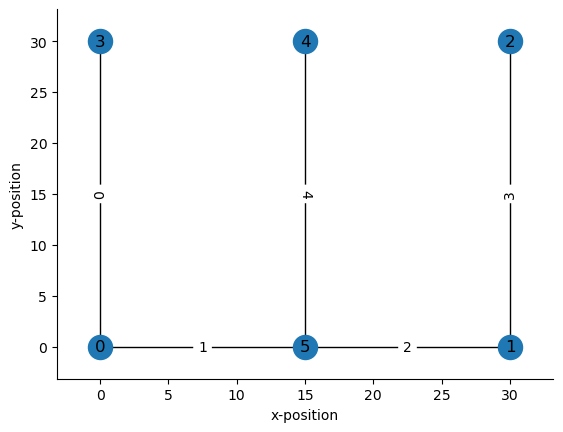

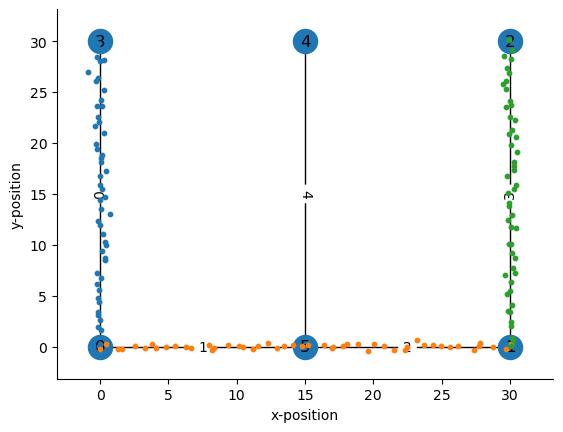

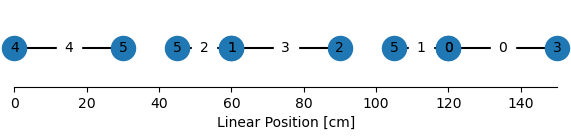

In [23]:
from track_linearization import (
    make_track_graph,
    plot_track_graph,
    plot_graph_as_1D,
    get_linearized_position,
)
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import multivariate_normal

node_positions = [(0, 0), (30, 0), (30, 30), (0, 30), (15, 30), (15, 0)]

edges = [
    (3, 0),
    (0, 5),
    (4, 5),
    (5, 1),
    (1, 2),
]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

x = np.linspace(0, 30)

position = np.concatenate(
    (
        np.stack((np.zeros_like(x), x[::-1]), axis=1),
        np.stack((x, np.zeros_like(x)), axis=1),
        np.stack((np.ones_like(x) * 30, x), axis=1),
    )
)
position += multivariate_normal(mean=0, cov=0.05).rvs(position.shape)

plt.scatter(position[:50, 0], position[:50, 1], s=10, zorder=11)
plt.scatter(position[50:100, 0], position[50:100, 1], s=10, zorder=11)
plt.scatter(position[100:, 0], position[100:, 1], s=10, zorder=11)


edge_order = [(4, 5), (5, 1), (1, 2), (5, 0), (0, 3)]
edge_spacing = [15, 0, 15, 0]

fig, ax = plt.subplots(figsize=(7, 1))
plot_graph_as_1D(
    track_graph,
    edge_spacing=edge_spacing,
    edge_order=edge_order,
    ax=ax,
    draw_edge_labels=True,
)


In [24]:
# determine edge
# find point on line between nodes 2D position


In [25]:
def get_projected_position(
    start_node_2D_position: np.ndarray,
    end_node_2D_position: np.ndarray,
    distance_from_start_node: np.ndarray,
) -> np.ndarray:
    angle = np.arctan2(
        end_node_2D_position[:, 1] - start_node_2D_position[:, 1],
        end_node_2D_position[:, 0] - start_node_2D_position[:, 0],
    )
    return np.stack(
        [
            start_node_2D_position[:, 0] + distance_from_start_node * np.cos(angle),
            start_node_2D_position[:, 1] + distance_from_start_node * np.sin(angle),
        ],
        axis=1,
    )


In [26]:
import pandas as pd

edge_id = []
start_node_2D_position = []
end_node_2D_position = []
start_node_linear_position = []
end_node_linear_position = []
start_nodes = []
end_nodes = []
distance = []

counter = 0.0

for edge_ind, (start_node, end_node) in enumerate(edge_order):
    edge_id.append(track_graph.edges[(start_node, end_node)]["edge_id"])
    start_node_2D_position.append(track_graph.nodes[start_node]["pos"])
    end_node_2D_position.append(track_graph.nodes[end_node]["pos"])
    start_node_linear_position.append(counter)
    end_node_linear_position.append(
        counter + track_graph.edges[(start_node, end_node)]["distance"]
    )
    start_nodes.append(start_node)
    end_nodes.append(end_node)
    distance.append(track_graph.edges[(start_node, end_node)]["distance"])

    try:
        counter += (
            track_graph.edges[(start_node, end_node)]["distance"]
            + edge_spacing[edge_ind]
        )
    except IndexError:
        pass

pd.DataFrame(
    {
        "edge_id": edge_id,
        "start_node_2D_position": start_node_2D_position,
        "end_node_2D_position": end_node_2D_position,
        "start_node_linear_position": start_node_linear_position,
        "end_node_linear_position": end_node_linear_position,
        "edge_order": edge_order,
        "start_nodes": start_nodes,
        "end_nodes": end_nodes,
        "distance": distance,
    }
)


,edge_id,start_node_2D_position,end_node_2D_position,start_node_linear_position,end_node_linear_position,edge_order,start_nodes,end_nodes,distance
0,4,"(15, 30)","(15, 0)",0.0,30.0,"(4, 5)",4,5,30.0
1,2,"(15, 0)","(30, 0)",45.0,60.0,"(5, 1)",5,1,15.0
2,3,"(30, 0)","(30, 30)",60.0,90.0,"(1, 2)",1,2,30.0
3,1,"(15, 0)","(0, 0)",105.0,120.0,"(5, 0)",5,0,15.0
4,0,"(0, 0)","(0, 30)",120.0,150.0,"(0, 3)",0,3,30.0


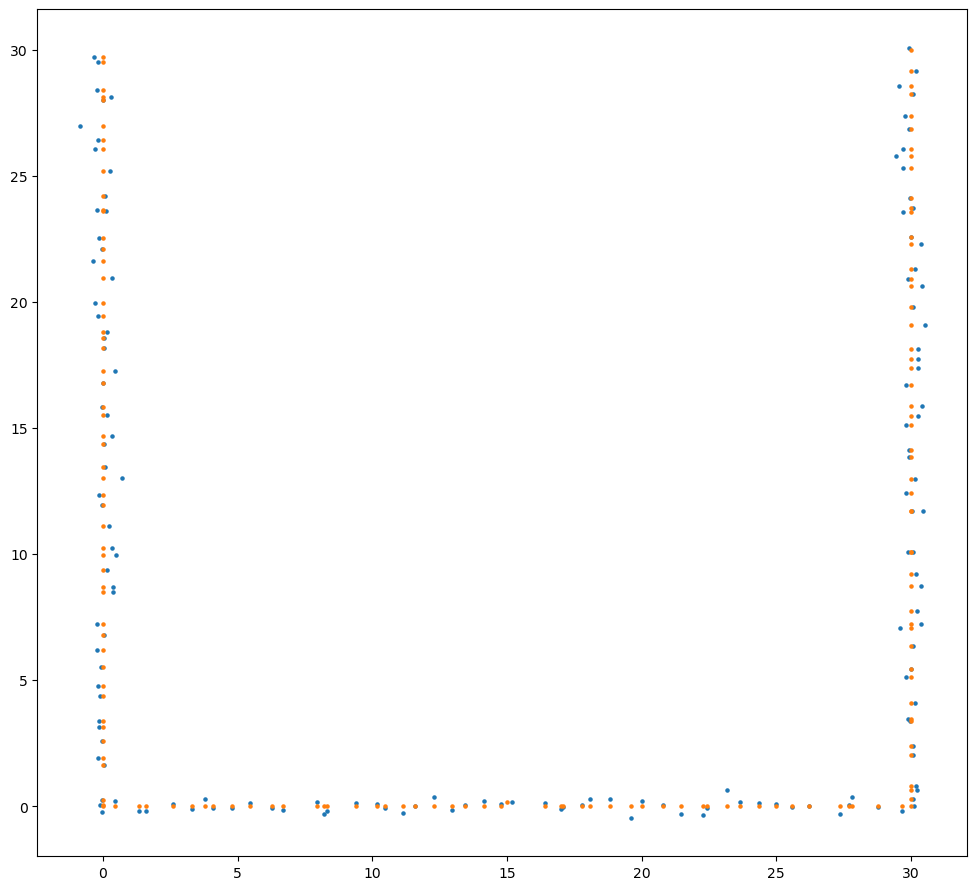

In [27]:
def get_2D_position_from_1D_position(
    linear_position, track_graph, edge_order, edge_spacing
):

    projected_position = np.zeros((linear_position.shape[0], 2))

    start_node_linear_position = 0.0

    for ind, (start_node, end_node) in enumerate(edge_order):

        end_node_linear_position = (
            start_node_linear_position
            + track_graph.edges[(start_node, end_node)]["distance"]
        )

        is_edge = (linear_position >= start_node_linear_position) & (
            linear_position <= end_node_linear_position
        )

        start_node_2D_position = track_graph.nodes[start_node]["pos"]
        end_node_2D_position = track_graph.nodes[end_node]["pos"]

        distance_from_start_node = linear_position[is_edge] - start_node_linear_position

        projected_position[is_edge] = get_projected_position(
            np.asarray(start_node_2D_position)[np.newaxis],
            np.asarray(end_node_2D_position)[np.newaxis],
            distance_from_start_node,
        )

        try:
            start_node_linear_position = end_node_linear_position + edge_spacing[ind]
        except IndexError:
            pass

    return projected_position


position_df = get_linearized_position(
    position=position,
    track_graph=track_graph,
    edge_spacing=edge_spacing,
    edge_order=edge_order,
    use_HMM=False,
)

linear_position = np.asarray(position_df.linear_position)
projected_position = get_2D_position_from_1D_position(
    linear_position, track_graph, edge_order, edge_spacing
)

plt.figure(figsize=(12, 11))
plt.scatter(position[:, 0], position[:, 1], s=5)
plt.scatter(projected_position[:, 0], projected_position[:, 1], s=5)


In [30]:
# project 1D position to 2D
position_time = np.arange(len(linear_position)) / 30
spike_times = position_time.copy()
# interpolate points
projected_position = get_2D_position_from_1D_position(
    linear_position, track_graph, edge_order, edge_spacing
)
position2D_at_spike_times = get_position_at_spike_times(
    position_time, projected_position, spike_times
)
# project back to 1D
position1D_at_spike_times = get_linearized_position(
    position=position2D_at_spike_times,
    track_graph=track_graph,
    edge_spacing=edge_spacing,
    edge_order=edge_order,
    use_HMM=False,
).linear_position.to_numpy()

np.allclose(position1D_at_spike_times, linear_position)


True

In [32]:
def get_1D_position_at_spike_times(
    spike_times, position_time, linear_position, track_graph, edge_order, edge_spacing
):
    # interpolate points
    projected_position = get_2D_position_from_1D_position(
        linear_position, track_graph, edge_order, edge_spacing
    )
    position2D_at_spike_times = get_position_at_spike_times(
        position_time, projected_position, spike_times
    )
    # project back to 1D
    return get_linearized_position(
        position=position2D_at_spike_times,
        track_graph=track_graph,
        edge_spacing=edge_spacing,
        edge_order=edge_order,
        use_HMM=False,
    ).linear_position.to_numpy()


get_1D_position_at_spike_times(
    [0.1, 0.2], position_time, linear_position, track_graph, edge_order, edge_spacing
)


array([148.12565892, 146.42133104])